Choose file to use as input.

In [1086]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_index = 3
data_files = [
    ('data/krwusd_1994-2024.csv', 'KRW/USD (1994-2024)'), # 0
    ('data/krwusd_2004-2024.csv', 'KRW/USD (2004-2024)'), # 1
    ('data/krwusd_2014-2024.csv', 'KRW/USD (2014-2024)'), # 2
    ('data/krwusd_2019-2024.csv', 'KRW/USD (2019-2024)'), # 3
    ('data/krwpln_1994-2024.csv', 'KRW/PLN (1994-2024)'), # 4
    ('data/krwpln_2004-2024.csv', 'KRW/PLN (2004-2024)'), # 5
    ('data/krwpln_2014-2024.csv', 'KRW/PLN (2014-2024)'), # 6
    ('data/krwpln_2019-2024.csv', 'KRW/PLN (2019-2024)'), # 7
]
file_name = data_files[file_index][0]
title = data_files[file_index][1]

Load and display the data

In [1087]:
data = pd.read_csv(file_name)[['Data', 'Otwarcie']]
data = data.rename(columns={'Data': 'Date', 'Otwarcie': 'Value'})
data['Date'] = pd.to_datetime(data['Date'])
display(data)

,Date,Value
0,2019-01-02,0.000897
1,2019-01-03,0.000891
2,2019-01-04,0.000889
3,2019-01-07,0.000897
4,2019-01-08,0.000895
...,...,...
1257,2023-12-25,0.000770
1258,2023-12-26,0.000772
1259,2023-12-27,0.000772
1260,2023-12-28,0.000772


Show exchange rate plot

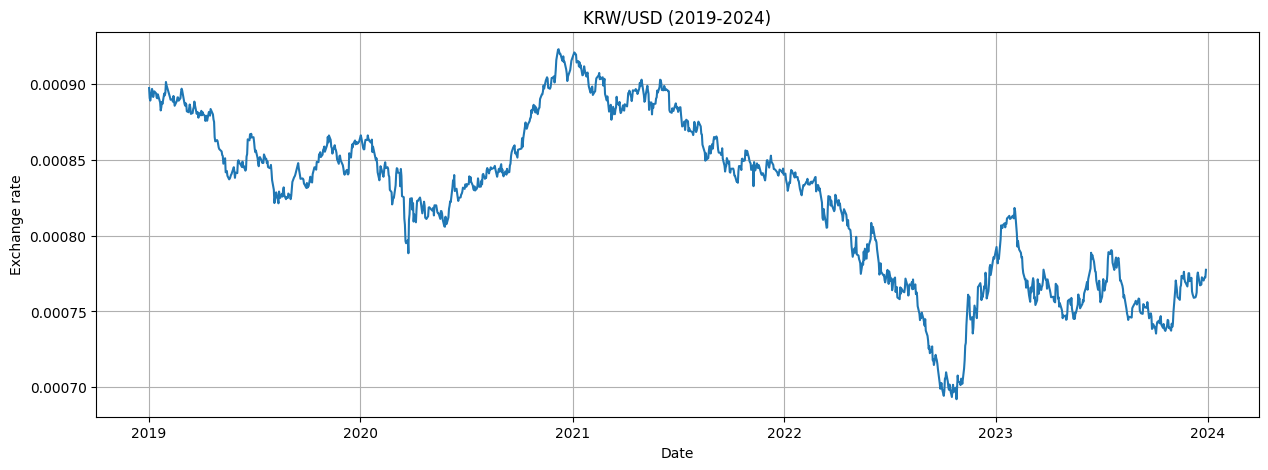

In [1088]:
def plot_exchange_rate(data, title):
    plt.figure(figsize=(15, 5))
    plt.plot(data['Date'], data['Value'])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Exchange rate')
    plt.grid()
    plt.show()

plot_exchange_rate(data, title)

Define `EMA`, `MACD` and `SIGNAL` functions

In [1089]:
def EMA(data: pd.Series, start_index: int, n: int) -> float:
    alfa = 2 / (n + 1)
    nominator = 0
    denominator = 0
    counter = 0
    for i in range(start_index, start_index-n-1, -1):
        if i < 0:
            raise ValueError(f'N={n} is too large for index={start_index}')
        if np.isnan(data[i]):
            raise ValueError(f'Value at index {i} is NaN')

        nominator += data[i] * (1 - alfa)**counter
        denominator += (1 - alfa)**counter
        counter += 1

    return nominator / denominator

def MACD(data: pd.Series, index: int) -> float:
    return EMA(data, index, 12) - EMA(data, index, 26)

def SIGNAL(data: pd.Series, index: int) -> float:
    return EMA(data, index, 9)

Calculate MACD and SIGNAL values. Find the points where MACD crosses SIGNAL.

In [1090]:
for record in data.iterrows():
    index = record[0]

    if index < 26:
        continue
    macd = MACD(data['Value'], index)
    data.at[index, 'MACD'] = macd
    
    if index < 35:
        continue
    signal = SIGNAL(data['MACD'], index)
    data.at[index, 'SIGNAL'] = signal

    prev_macd = data.at[index-1, 'MACD']
    prev_signal = data.at[index-1, 'SIGNAL']
    if np.isnan(prev_macd) or np.isnan(prev_signal):
        continue

    if prev_macd < prev_signal and macd > signal:
        data.at[index, 'Action'] = 'BUY'
    elif prev_macd > prev_signal and macd < signal:
        data.at[index, 'Action'] = 'SELL'


display(data[data['Action'].notna()])

,Date,Value,MACD,SIGNAL,Action
36,2019-02-26,0.000894,-1.682987e-07,-3.882004e-07,BUY
40,2019-03-05,0.000886,-2.434758e-07,2.902152e-08,SELL
52,2019-03-21,0.000888,-1.784154e-06,-2.138340e-06,BUY
57,2019-03-28,0.000878,-2.054172e-06,-1.926335e-06,SELL
60,2019-04-02,0.000882,-1.766793e-06,-1.889743e-06,BUY
...,...,...,...,...,...
1170,2023-08-24,0.000752,-8.829102e-06,-9.597370e-06,BUY
1190,2023-09-21,0.000750,-2.215568e-08,2.585105e-07,SELL
1202,2023-10-09,0.000744,-3.519226e-06,-3.757650e-06,BUY
1235,2023-11-23,0.000769,7.712246e-06,7.737574e-06,SELL


Show MACD and SIGNAL plot

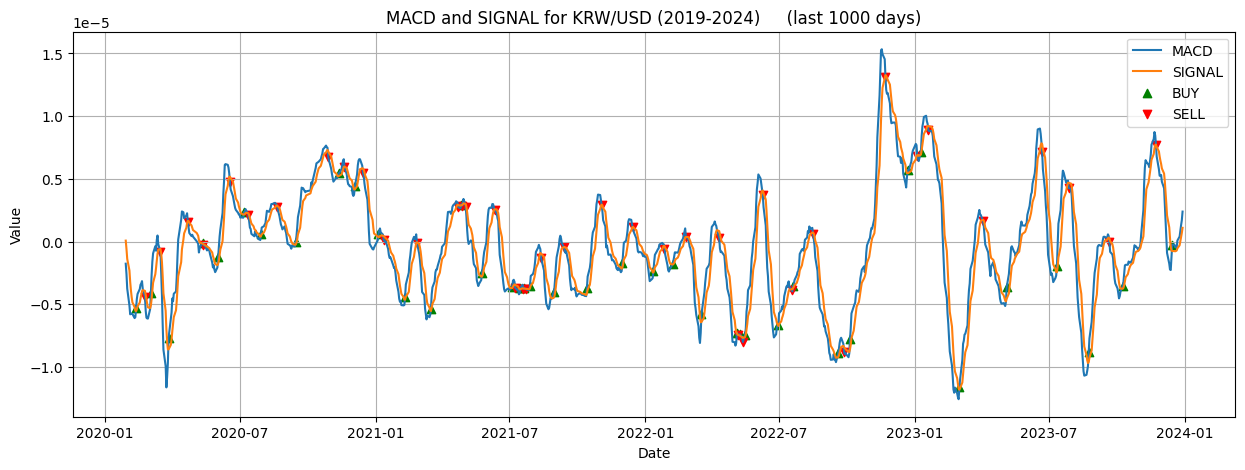

In [1091]:
def plot_MACD_and_SIGNAL(data, title='MACD and SIGNAL'):
    buy_data = data[data['Action'] == 'BUY']
    sell_data = data[data['Action'] == 'SELL']

    plt.figure(figsize=(15, 5))
    plt.plot(data['Date'], data['MACD'])
    plt.plot(data['Date'], data['SIGNAL'])
    plt.scatter(buy_data['Date'], buy_data['MACD'], color='green', marker='^')
    plt.scatter(sell_data['Date'], sell_data['MACD'], color='red', marker='v')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid()
    plt.legend(['MACD', 'SIGNAL', 'BUY', 'SELL'])
    plt.show()
    
days_count = 1000
tailed_data = data.tail(days_count)
plot_MACD_and_SIGNAL(tailed_data, title=f'MACD and SIGNAL for {title}     (last {min(days_count, len(data))} days)')

Simulate trading using MACD and SIGNAL.

In [1092]:
initial_balance = 1_000
instrument_balance = initial_balance
alt_balance = 0

for record in tailed_data.iterrows():
    index = record[0]
    record_data = record[1]

    if record_data['Action'] == 'BUY':
        if alt_balance == 0:
            continue
        instrument_bought = alt_balance / record_data['Value']
        instrument_balance += instrument_bought
        alt_balance = 0
    elif record_data['Action'] == 'SELL':
        if instrument_balance == 0:
            continue
        alt_bought = instrument_balance * record_data['Value']
        alt_balance += alt_bought
        instrument_balance = 0

if alt_balance > 0:
    last_value = tailed_data.tail(1)['Value'].values[0]
    instrument_balance += alt_balance / last_value
    alt_balance = 0


print(f'Initial balance: {initial_balance:.2f}')
print(f'Final balance: {instrument_balance:.2f}')
print(f'Profit: {instrument_balance - initial_balance:.2f} ({(instrument_balance - initial_balance) / initial_balance * 100:.2f}%)')

Initial balance: 1000.00
Final balance: 1047.33
Profit: 47.33 (4.73%)
